In [ ]:
!pip install torchmetrics

In [1]:
!unzip -q train_set.zip
!unzip -q utils.zip

In [1]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM
from dataclasses import dataclass
import dataclasses

# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

# Set the working (writable) directory.
working_dir = "/content/"

In [2]:


from utils.models import VisionTransformerForSegmentation
from utils.helpers import *
from utils.dataset import *
from utils.validation import IoULoss
from utils.test import *


CUDA: True


In [ ]:
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

In [ ]:
# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.

# The above explanation is misleading
# trimap2f() is actually convert trimap {0,1,2} into values in range (0,127)
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2
# Spot check a segmentation mask image after post-processing it
# via trimap2f().
(train_pets_input, train_pets_target) = pets_train_orig[0]
temp = np.array(t2img(trimap2f(train_pets_target)))

In [ ]:
np.array(temp)[:10,:10]

In [ ]:
# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)
        # print(f'*********{target[0,:5,:5]}') before feeding transform, already is float
        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)
# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
    ]),
)

pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=64,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
#(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
#train_pets_inputs.shape, train_pets_targets.shape

In [ ]:
train_pets_targets[:5,:5]

In [ ]:

temp = tensor_trimap(train_pets_targets)

In [ ]:
torch.unique(temp)

tensor([0, 1, 2])

In [ ]:
temp[:5,:5]

In [ ]:
torch.unique(train_pets_targets * 255)

tensor([1., 2., 3.])

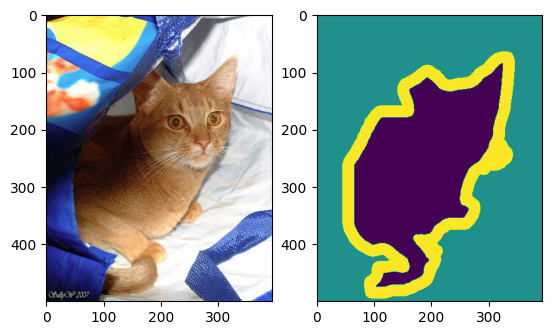

In [ ]:
image = np.array(pets_train_orig.__getitem__(0)[0])
target =np.array(pets_train_orig.__getitem__(0)[1])
sample = [image, target]
fig, axs = plt.subplots(ncols=len(sample), squeeze=False)
for i, cont in enumerate(sample):
  axs[0,i].imshow(cont)


In [ ]:
np.array(pets_train_orig.__getitem__(0)[0])[:10,:10] #dtype=uint8, image:(h,w,c)
np.array(pets_train_orig.__getitem__(0)[1])[190:200,100:110] #dtype=uint8, mask:(h,w), values: 1,2,3
# object:1, boundary:3, background:2

In [ ]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2
# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"

In [3]:
@dataclass
class VisionTransformerArgs:
    #Arguments to the VisionTransformerForSegmentation.
    image_size: int = 128
    patch_size: int = 16
    in_channels: int = 3
    out_channels: int = 2 # This is a binary segmentation problem. Only foreground and backgroud. So out_channels = 2
    embed_size: int = 768
    num_blocks: int = 12
    num_heads: int = 8
    dropout: float = 0.2
print_title("VisionTransformerForSegmentation")
x = torch.randn(2, 3, 128, 128)
vit_args = dataclasses.asdict(VisionTransformerArgs())

vit = VisionTransformerForSegmentation(**vit_args)
y = vit(x)
print(f"{x.shape} -> {y.shape}")
print_model_parameters(vit)


VisionTransformerForSegmentation
--------------------------------
torch.Size([2, 3, 128, 128]) -> torch.Size([2, 2, 128, 128])
The Model has 86.09M parameters


In [4]:
base_dir = '/content/train_set/'
with open('train.lst', "r") as f:
    lines = f.read().splitlines()
n = len(lines) # 3017 for training
splits = [lines[i].split() for i in range(n)]
inputs = [splits[i][0] for i in range(n)]
targets = [splits[i][1] for i in range(n)]
img_paths = [base_dir + inputs[i] for i in range(n)]
mask_paths = [base_dir + targets[i] for i in range(n)]
image_lst, mask_lst = img_paths[:500], mask_paths[:500]

In [ ]:
#image_lst, mask_lst = prepareList()
my_dataset = SegmentationDataSet(image_lst, mask_lst)

In [ ]:
mask[0,:3,:3]

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

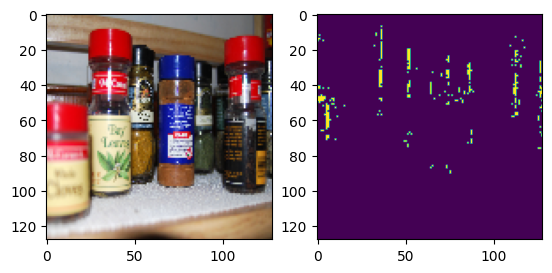

In [ ]:
img, mask = my_dataset.__getitem__(0)
# during preprocessing, change the int type into float, causing trouble to display the image
# after standarding by dividing 255 in dataset preparing, following is not needed anymore
# img = img.type(torch.int)
sample = [img, mask]
fig, axs = plt.subplots(ncols=len(sample), squeeze=False)
for i, cont in enumerate(sample):
  axs[0,i].imshow(cont.permute(1,2,0))
# note: when displaying images using plt.imshow() or ax.imshow(), the matrix can be np.ndarray
# or torch.Tensor. If the dtype == float, the values must be in range(0,1); If the dtype==int,
# the values must be in range(0,255)

In [ ]:
mask[0,50:60, :20] # the mask value is 0, 4, 1, 250, 253...

In [ ]:
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"

In [9]:
# Train the model for a single epoch
def train_model(model, loader, optimizer):
    to_device(model.train())
    cel = True
    if cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True)
    # end if

    running_loss = 0.0
    running_samples = 0

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        optimizer.zero_grad()
        inputs = to_device(inputs)
        targets = to_device(targets)
        outputs = model(inputs)

        # The ground truth labels have a channel dimension (NCHW).
        # We need to remove it before passing it into
        # CrossEntropyLoss so that it has shape (NHW) and each element
        # is a value representing the class of the pixel.
        if cel:
            targets = targets.squeeze(dim=1)
        # end if
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_samples += targets.size(0)
        running_loss += loss.item()
    # end for

    print("Trained {} samples, Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))

In [6]:
# Optimizer and Learning Rate Scheduler.
m = vit
to_device(m)
optimizer = torch.optim.Adam(m.parameters(), lr=0.0004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.8)
# scheduler = None

In [7]:
def train_loop(model, loader, epochs, optimizer, scheduler, save_path):
    epoch_i, epoch_j = epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        if scheduler is not None:
            scheduler.step()
        print("")


In [10]:
my_dataset = SegmentationDataSet(image_lst, mask_lst)
train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=16, shuffle=True)
train_loop(m, train_loader, (1, 100), optimizer, scheduler, save_path=None)

Epoch: 01, Learning Rate: 0.0004
Trained 500 samples, Loss: 0.3802

Epoch: 02, Learning Rate: 0.0004
Trained 500 samples, Loss: 0.0676

Epoch: 03, Learning Rate: 0.0004
Trained 500 samples, Loss: 0.0558

Epoch: 04, Learning Rate: 0.0004
Trained 500 samples, Loss: 0.0545

Epoch: 05, Learning Rate: 0.0004
Trained 500 samples, Loss: 0.0468

Epoch: 06, Learning Rate: 0.0004
Trained 500 samples, Loss: 0.0440

Epoch: 07, Learning Rate: 0.0004
Trained 500 samples, Loss: 0.0435

Epoch: 08, Learning Rate: 0.0004
Trained 500 samples, Loss: 0.0425

Epoch: 09, Learning Rate: 0.0004
Trained 500 samples, Loss: 0.0399

Epoch: 10, Learning Rate: 0.00032
Trained 500 samples, Loss: 0.0368

Epoch: 11, Learning Rate: 0.00032
Trained 500 samples, Loss: 0.0354

Epoch: 12, Learning Rate: 0.00032
Trained 500 samples, Loss: 0.0343

Epoch: 13, Learning Rate: 0.00032
Trained 500 samples, Loss: 0.0312

Epoch: 14, Learning Rate: 0.00032
Trained 500 samples, Loss: 0.0294

Epoch: 15, Learning Rate: 0.00032
Trained 5

In [12]:
pred.shape

torch.Size([1, 2, 128, 128])

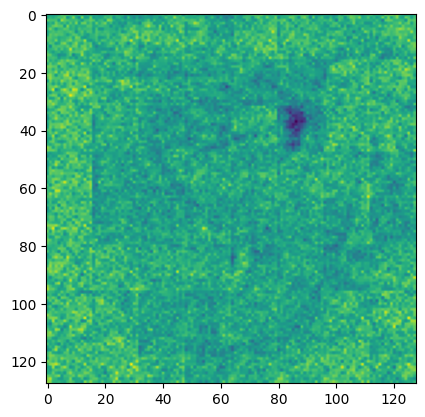

In [16]:
pred = m(my_dataset.__getitem__(2)[0].unsqueeze(0).cuda())
r = pred.cpu().detach()
plt.imshow(r[0,0])

In [ ]:
t[0,:3,:3]

tensor([[115, 154,  68],
        [120, 112, 178],
        [111,  78, 147]], dtype=torch.int32)

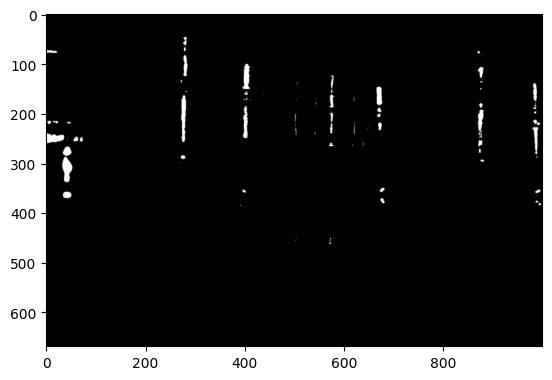

In [ ]:
from torchvision.io import read_image
from matplotlib import pyplot as plt
label = read_image('train_set/HighlightMasks/00001.png')
plt.imshow(label.permute(1,2,0))

In [ ]:
transform_label = T.Resize((128,128))(label)[0].unsqueeze(0).unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
transform_label.shape

torch.Size([1, 1, 128, 128])

In [ ]:
IoULoss(softmax=True)(pred, transform_label.cuda())

tensor(0.0376, device='cuda:0', grad_fn=<NegBackward0>)

In [ ]:
transform_label

In [ ]:
temp = nn.Softmax(dim=1)(pred)
temp[0,0,0:3,:3]

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0', grad_fn=<SliceBackward0>)